In [1]:
import os
import random
from typing import List


import numpy as np
import tensorflow as tf

tf.enable_eager_execution()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.InteractiveSession(config=config)

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
def sequence_list_from_file(file, is_dev_file=True):
    '''
    Return a list of sequences from a file.
    @file - Either a string or a keras file obj.
    @is_dev_file - Whether to read the dev file.
    '''
    if is_dev_file:
        return get_sequence_list_from_dev_file(file)
    else:
        return get_sequence_list_from_train_file(file)
    
    
def get_sequence_list_from_dev_file(file):
    with open(file, 'r') as sequence_file:
        sequence_text = sequence_file.read() \
                                     .replace('-', '')
        return sequences.split('\n')

    
def get_sequence_list_from_train_file(file):
    sequences = list()
    with open(file, 'r') as sequence_file:
        for iter_, line in enumerate(sequence_file):
            if (iter_ + 1) % 2 == 0:
                sequences.append(line.strip())
    return sequences

In [3]:
repo = 'https://raw.githubusercontent.com/badriadhikari'
remote_data_path = 'DEEPCON/master/deepcon-covariance/test'
dev_file = '16pkA0.aln'

local_data_path = '/home/das-hund/PycharmProjects/autoencoders/data'
train_file = 'pdb_seqres.txt'

dev_file_path = os.path.join(
    repo, remote_data_path, dev_file
)
train_file_path = os.path.join(
    local_data_path, train_file
)

print(f'[+] Train File Path: {train_file_path}')
print(f'[+] Dev File Path: {dev_file_path}')

[+] Train File Path: /home/das-hund/PycharmProjects/autoencoders/data/pdb_seqres.txt
[+] Dev File Path: https://raw.githubusercontent.com/badriadhikari/DEEPCON/master/deepcon-covariance/test/16pkA0.aln


In [4]:
IS_DEV_FILE = False
SEQUENCE_COUNT_LIMIT = 180000
PRINT_ACID_COUNT = 500

if IS_DEV_FILE:
    file_path = dev_file_path
else:
    file_path = train_file_path

sequence_list = sequence_list_from_file(file=file_path, is_dev_file=IS_DEV_FILE)
random.shuffle(sequence_list)

if SEQUENCE_COUNT_LIMIT is not None:
    sequence_list = sequence_list[:SEQUENCE_COUNT_LIMIT]
    
sequences = '.'.join(sequence_list)

print(f'[+] First {PRINT_ACID_COUNT} acids:\n\t{sequences[:PRINT_ACID_COUNT]}')

[+] First 500 acids:
	PKRGKKGAVAEDGDELRTEPEAKKSKTAAKKNDKEAAGEGPALYEDPPDQKTSPSGKPATLKICSWNVDGLRAWIKKKGLDWVKEEAPDILCLQETKCSENKLPAELQELPGLSHQYWSAPSDKEGYSGVGLLSRQCPLKVSYGIGDEEHDQEGRVIVAEFDSFVLVTAYVPNAGRGLVRLEYRQRWDEAFRKFLKGLASRKPLVLCGDLNVAHEEIDLRNPKGNKKNAGFTPQERQGFGELLQAVPLADSFRHLYPNTPYAYTFWTYMMNARSKNVGWRLDYFLLSHSLLPALCDSKIRSKALGSDHCPITLYLAL.XXXXXXXX.PIVQNLQGQMVHQAISPRTLNAWVKVVEEKAFSPEVIPMFSALSEGATPQDLNTMLNTVGGHQAAMQMLKETINEEAAEWDRLHPVHAGPIEPGQMREPRGSDIAGTTSTLQEQIGWMTHNPPIPVGEIYKRWIILGLNKIVRMYSPTSILDIRQGPKEPFRDYVDRFYKTLR


In [5]:
distinct_amino_acids = sorted(set(sequences))
distinct_amino_acid_count = len(distinct_amino_acids)
print(
  f'[+] {distinct_amino_acid_count - 1} Distinct Amino Acids in {file_path}'
)

[+] 25 Distinct Amino Acids in /home/das-hund/PycharmProjects/autoencoders/data/pdb_seqres.txt


In [6]:
amino_acid_to_index = {
  amino_acid: index 
  for index, amino_acid in enumerate(distinct_amino_acids)
}
index_to_amino_acid = np.array(distinct_amino_acids)

In [7]:
def pretty_print_dict(d: dict, length=0):
    print('{')
    for k, v in d.items():
        print(f'\t{k}: {v}')
    print('}')

print('[+] Amino Acid to Index:')
pretty_print_dict(amino_acid_to_index)
print(f'[+] Index to Amino Acids:\n{index_to_amino_acid}')

[+] Amino Acid to Index:
{
	.: 0
	A: 1
	B: 2
	C: 3
	D: 4
	E: 5
	F: 6
	G: 7
	H: 8
	I: 9
	K: 10
	L: 11
	M: 12
	N: 13
	O: 14
	P: 15
	Q: 16
	R: 17
	S: 18
	T: 19
	U: 20
	V: 21
	W: 22
	X: 23
	Y: 24
	Z: 25
}
[+] Index to Amino Acids:
['.' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R'
 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z']


In [8]:
sequences_as_int = np.array(
  [amino_acid_to_index[amino_acid] for amino_acid in sequences]
)
print(f'[+] {sequences[:20]} mapped to int {sequences_as_int[:20]}')

[+] PKRGKKGAVAEDGDELRTEP mapped to int [15 10 17  7 10 10  7  1 21  1  5  4  7  4  5 11 17 19  5 15]


In [9]:
sequences_as_int.shape

(45836450,)

In [10]:
SEQUENCE_LENGTH = 100
examples_per_epoch = len(sequences_as_int) // SEQUENCE_LENGTH

sequence_dataset = tf.data.Dataset.from_tensor_slices(sequences_as_int)

print('First 5 Acids:')
for i in sequence_dataset.take(5):
    print(index_to_amino_acid[i.numpy()])

First 5 Acids:
Instructions for updating:
Colocations handled automatically by placer.
P
K
R
G
K


In [11]:
sequences = sequence_dataset.batch(SEQUENCE_LENGTH + 1, drop_remainder=True)

for item in sequences.take(5):
    print(repr(''.join(index_to_amino_acid[item.numpy()])))

'PKRGKKGAVAEDGDELRTEPEAKKSKTAAKKNDKEAAGEGPALYEDPPDQKTSPSGKPATLKICSWNVDGLRAWIKKKGLDWVKEEAPDILCLQETKCSEN'
'KLPAELQELPGLSHQYWSAPSDKEGYSGVGLLSRQCPLKVSYGIGDEEHDQEGRVIVAEFDSFVLVTAYVPNAGRGLVRLEYRQRWDEAFRKFLKGLASRK'
'PLVLCGDLNVAHEEIDLRNPKGNKKNAGFTPQERQGFGELLQAVPLADSFRHLYPNTPYAYTFWTYMMNARSKNVGWRLDYFLLSHSLLPALCDSKIRSKA'
'LGSDHCPITLYLAL.XXXXXXXX.PIVQNLQGQMVHQAISPRTLNAWVKVVEEKAFSPEVIPMFSALSEGATPQDLNTMLNTVGGHQAAMQMLKETINEEA'
'AEWDRLHPVHAGPIEPGQMREPRGSDIAGTTSTLQEQIGWMTHNPPIPVGEIYKRWIILGLNKIVRMYSPTSILDIRQGPKEPFRDYVDRFYKTLRAEQAS'


In [12]:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

dataset = sequences.map(split_input_target)

In [13]:
for input_example, target_example in  dataset.take(1):
    print ('Input data: ', repr(''.join(index_to_amino_acid[input_example.numpy()])))
    print ('Target data:', repr(''.join(index_to_amino_acid[target_example.numpy()])))

Input data:  'PKRGKKGAVAEDGDELRTEPEAKKSKTAAKKNDKEAAGEGPALYEDPPDQKTSPSGKPATLKICSWNVDGLRAWIKKKGLDWVKEEAPDILCLQETKCSE'
Target data: 'KRGKKGAVAEDGDELRTEPEAKKSKTAAKKNDKEAAGEGPALYEDPPDQKTSPSGKPATLKICSWNVDGLRAWIKKKGLDWVKEEAPDILCLQETKCSEN'


In [14]:
BATCH_SIZE = 64
steps_per_epoch = examples_per_epoch // BATCH_SIZE

dataset = dataset.shuffle(buffer_size=10000).batch(
    batch_size=BATCH_SIZE, drop_remainder=True
)

print(f'[+] Examples Per Epoch: {examples_per_epoch}')
print(f'[+] Steps Per Epoch: {steps_per_epoch}')
print(f'[+] Batch Size: {BATCH_SIZE}')
dataset

[+] Examples Per Epoch: 458364
[+] Steps Per Epoch: 7161
[+] Batch Size: 64


<DatasetV1Adapter shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

In [15]:
RNN_UNITS = 1024
EMBEDDING_DIM = 256

In [16]:
def build_model(vocab_size: int, embed_dim: int, 
                rnn_units: int, batch_size: int):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(
            vocab_size, embed_dim, 
            batch_input_shape=[batch_size, None],
            name='embedding'
        ),
        tf.keras.layers.CuDNNLSTM(
          rnn_units, return_sequences=True,
          recurrent_initializer='glorot_uniform',
          stateful=True, name='lstm'
        ),
        tf.keras.layers.Dense(vocab_size, name='dense_out')
    ])
    return model

In [17]:
model = build_model(
  vocab_size=distinct_amino_acid_count,
  embed_dim=EMBEDDING_DIM, rnn_units=RNN_UNITS, 
  batch_size=BATCH_SIZE
)

In [18]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           6656      
_________________________________________________________________
lstm (CuDNNLSTM)             (64, None, 1024)          5251072   
_________________________________________________________________
dense_out (Dense)            (64, None, 26)            26650     
Total params: 5,284,378
Trainable params: 5,284,378
Non-trainable params: 0
_________________________________________________________________


In [19]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 26) # (batch_size, sequence_length, vocab_size)


In [20]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [21]:
sampled_indices

array([25, 21,  2, 17,  1, 23, 20,  6, 16, 20, 25, 22, 14,  7, 21, 18,  1,
        8, 20, 10,  3, 23, 23, 12,  9, 12,  5, 13,  7,  4,  8,  2, 12,  0,
        5,  5,  3,  5, 17,  0,  1,  6, 21, 25, 16,  0, 23, 16, 23, 18,  3,
       24,  4,  7,  0, 16,  8, 23,  5,  9,  9,  3, 21, 22,  4, 19, 15, 23,
       10,  4,  8, 20, 12, 11,  4, 24, 12, 17, 13,  4, 24,  7,  3,  1, 11,
        5,  4, 14, 11, 12,  2, 15, 24, 11,  0, 22, 17,  9, 10,  4])

In [22]:
print("Input: \n", repr("".join(index_to_amino_acid[input_example_batch[0]])))
print()
print("Next Acid Predictions: \n", repr("".join(index_to_amino_acid[sampled_indices ])))

Input: 
 'GNSPTEILAATFERLNIETGVNVQAALAAAEEVVRPYLPRLPWADRAAIVQGYAGVYSSFLLHAERAAERYGVPAHEILQRVGEAGYVGGQEDMIIDIAV'

Next Acid Predictions: 
 'ZVBRAXUFQUZWOGVSAHUKCXXMIMENGDHBM.EECER.AFVZQ.XQXSCYDG.QHXEIICVWDTPXKDHUMLDYMRNDYGCALEDOLMBPYL.WRIKD'


In [23]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(
        labels, logits, from_logits=True
    )

model.compile(
    optimizer=tf.train.AdamOptimizer(),
    loss=loss
)

In [24]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(
    checkpoint_dir, 'rnnlm.weights.kla.hdf5'
)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,
    monitor='loss',
    verbose=1, save_best_only=True, 
    mode='min'
)

In [25]:
EPOCHS = 12

FIT_MODEL = True

if FIT_MODEL:
    history = model.fit(
      dataset.repeat(), epochs=EPOCHS, 
      steps_per_epoch=steps_per_epoch, callbacks=[checkpoint_callback]
    )

Epoch 1/12
7160/7161 [============================>.] - ETA: 0s - loss: 2.4984
Epoch 00001: loss improved from inf to 2.49839, saving model to ./training_checkpoints/rnnlm.weights.kla.hdf5
7161/7161 [==============================] - 369s 51ms/step - loss: 2.4984
Epoch 2/12
7159/7161 [============================>.] - ETA: 0s - loss: 2.0818
Epoch 00002: loss improved from 2.49839 to 2.08173, saving model to ./training_checkpoints/rnnlm.weights.kla.hdf5
7161/7161 [==============================] - 369s 51ms/step - loss: 2.0817
Epoch 3/12
7160/7161 [============================>.] - ETA: 0s - loss: 1.9792
Epoch 00003: loss improved from 2.08173 to 1.97922, saving model to ./training_checkpoints/rnnlm.weights.kla.hdf5
7161/7161 [==============================] - 368s 51ms/step - loss: 1.9792
Epoch 4/12
7159/7161 [============================>.] - ETA: 0s - loss: 1.9287
Epoch 00004: loss improved from 1.97922 to 1.92868, saving model to ./training_checkpoints/rnnlm.weights.kla.hdf5
7161/71

In [26]:
model = build_model(
  vocab_size=distinct_amino_acid_count,
  embed_dim=EMBEDDING_DIM, rnn_units=RNN_UNITS, 
  batch_size=1
)
model.load_weights(checkpoint_prefix)
model.build(tf.TensorShape([1, None]))

Using TensorFlow backend.


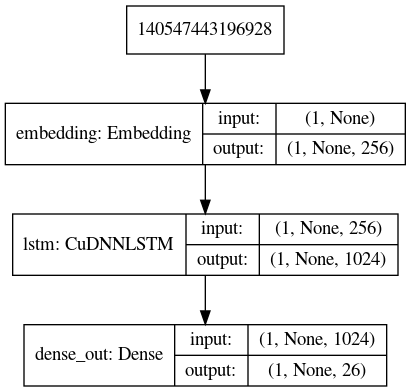

In [27]:
from keras.utils import plot_model
from IPython.display import Image
plot_model(model, show_shapes=True, show_layer_names=True, to_file='rnnlm.png')
Image(retina=True, filename='rnnlm.png')

In [28]:
def generate_text(model, start_string):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 1000

    # Converting our start string to numbers (vectorizing)
    input_eval = [amino_acid_to_index[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperatures results in more predictable text.
    # Higher temperatures results in more surprising text.
    # Experiment to find the best setting.
    temperature = 1.0

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a multinomial distribution to predict the word returned by the model
        predictions = predictions / temperature
        predicted_id = tf.multinomial(predictions, num_samples=1)[-1,0].numpy()

        # We pass the predicted word as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(index_to_amino_acid[predicted_id])

    return (start_string + ''.join(text_generated))

In [29]:
print(generate_text(model, start_string=u"EKKSINE"))

Instructions for updating:
Use tf.random.categorical instead.
EKKSINE.MAMGAAKNSTSVLALKTTGMWQTDKRFSNRFGDAGLKAGRPDQVQGVLKTLNILSSASGADFTAMPYKFQNHPMDRVAVTPIPENFKIHKYEAGVIGNYDTVDSQYPEQYNSVPFPPIRIPLMIKPGNKERFATVMDSEYDLSNKSVPSFETRLFYTPEYSSMNLIKKTLKAYASGRYWDWEILSVVPT.UUGUUGGGAGGGCGCAGCGGUCUCCCCAAUGGGCGUAAAGGUCCUUGGUGGCGGCACAGUCUUUGGUAAUUAUUGAAACGUUGUCAUGUACUAGGGAACCCGGAAGGGAGGGGGAGUGGUGGAAUUCCAGUAGAUGGAAAAUGCAAUGUGAACUUGGAAUGGCCUACAAGGUGCCCUGCUU.MVYQTDGLQFSLPPSDERDMIARAIHWESPDKQIYTLIDKDYLEIVKQDTKIGNHFFSVEEAQQLIAAQLKSGAGGCGGACGGAAAGUCCGCGGCCGUGGACCCGAAACCGGUCGGUGAGAGCACGAUAGUGAUCCGGUGGGGCCCAUGCCCAGAAGGGAGCCAAGGGUAGAAGGGGGCCUGAGAACCGUAAGGUAGCCGUAAUGUGAAUUGCAGAAUUCCGUGAAUCAUCGAAUCUUUGAACGCACAUUGCGCCCCUUGGUAUUCCAGGGGGCAUGCCUGUUUGAACGCCUGCAAGCCCCAAACGACACAAGGGUUCCUGUCGGCADKPGGSPALNDDPILRSVDLRALSRHAVRTMALGRDHQALAVLLFASERALRAAQRTGREQLAYLDHTPREALDVMQKIVEQAKLKGIEDVRQVAKCLLPEYRRYEDGEEGGWLMQDALPALMGGDQIVSHVHSQRPVFFTFDRLHAEELQAEVNRSLKPVAELLKIKEGYVVSLDVSDLLLIQQRTIHRPEHICVLEIGQEVNTGSKGYLAWRYRNYWDYGSWGTFFTQQ